# Imaging and image representation

In [1]:
from pyrt.math import Vec3
from pyrt.scene import Scene
from pyrt.light import PointLight, AmbientLight
from pyrt.geometry import Sphere, Parallelepiped, ClosedCylinder, PlanarTexture, Parallelogram, Triangle, Vertex, Cylinder, Parallelepiped
from pyrt.material import PhongMaterial
from pyrt.camera import PerspectiveCamera
from pyrt.renderer import SimpleRT
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Ray tracing
First, we initialize the scene and the rendering engine.

In [2]:
scene = Scene()
engine = SimpleRT(shadow=True, iterations=1)

# Creating Renderer: Simple Raytracer
# Shadow Enabled


Then we define the rendering resolution and the camera.

In [3]:
scale = 2
width = 320 * scale
height = 240 * scale

The camera we use has 60 degrees field of view. It is located at (-2.5, -15, 2) and it is pointing to (-2.5, 0, 2). The image vertical axis is along with the vector (0, 0, 1).

In [4]:
camera = PerspectiveCamera(width, height, 60)
camera.setView(Vec3(-2.5,-15.,2.), Vec3(-2.5,0.,2.), Vec3(0.,0.,1.))
scene.setCamera(camera)

We first use one ambient light source.

In [5]:
scene.addLight(AmbientLight(brightness=1.0))

We need some materials for the objects.

In [6]:
wall = PhongMaterial(color=Vec3(192.0/255,0,0), reflectivity=.0)
grass = PhongMaterial(color=Vec3(0,0.8,0), reflectivity=.0)
white = PhongMaterial(color=Vec3(1,1,1), reflectivity=.0)
ball = PhongMaterial(color=Vec3(0,0,0.9), reflectivity=.5)
trunk = PhongMaterial(color=Vec3(132.0/255,60.0/255,12.0/255), reflectivity=.0)
leaves = PhongMaterial(color=Vec3(38.0/255,162.0/255,67.0/255), reflectivity=.0)
cube = PhongMaterial(color=Vec3(229.0/255,188.0/255,23.0/255), reflectivity=.0)

The house is rendered using textures from two images.

In [7]:
side1 = cv2.imread("images/house-1.png")
side2 = cv2.imread("images/house-2.png")

OpenCV uses BGR color representation that needs to be transformed to RGB. The image y axis is downwards, and it must be flipped to upwards.

In [8]:
side1 = cv2.cvtColor(side1,cv2.COLOR_BGR2RGB)
side1 = side1[::-1,:]
side2 = cv2.cvtColor(side2,cv2.COLOR_BGR2RGB)
side2 = side2[::-1,:]

Next, we add the objects to the scene.

In [9]:
scene.add(Parallelogram(Vec3(-9,-12,0),Vec3(18,0,0),Vec3(0,25,0), grass))
scene.add(PlanarTexture(Vec3(-4,-6,0),Vec3(3,0,0),Vec3(0,0,3),side1, white))
scene.add(PlanarTexture(Vec3(-1,-6,0),Vec3(0,6,0),Vec3(0,0,3),side2, white))
scene.add(Parallelogram(Vec3(-1,-6,3),Vec3(0,6,0),Vec3(-1.5,0,1.5), trunk))
scene.add(Triangle(Vertex(position=(-4, -6, 3)), Vertex(position=(-1, -6, 3)), Vertex(position=(-2.5, -6, 4.5)), wall))
scene.add(Sphere(Vec3(3.0,-6.,1.), 1., ball))
scene.add(Cylinder(Vec3(3.,5.,0.0), Vec3(0.,0.,5.0), 0.3, trunk))
scene.add(Sphere(Vec3(3.,5.,5.0+3.0), 3, leaves))
scene.add(Parallelepiped(Vec3(-2.0,-9.5,0),Vec3(0.5,-0.5,0),Vec3(0.5,0.5,0),Vec3(0,0,0.7), cube))

Finally, we can render the image.

In [10]:
image = engine.render(scene)

# RENDER STATISTICS###############################
TIME FOR RENDERING: 100.10652756690979s
NUMBER OF PRIMARY RAYS: 307200
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 3068.7309555780153
##################################################


Let's see how it looks like.

(-0.5, 639.5, 479.5, -0.5)

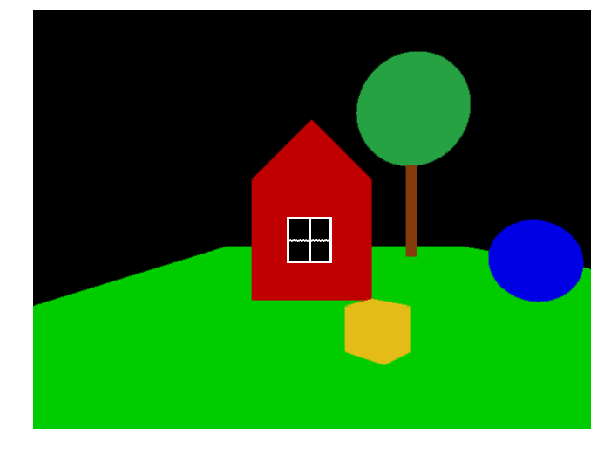

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image.data)
plt.axis('off')

Now, we can change the camera viewpoint and render again.

In [12]:
camera.setView(Vec3(6,-13.,2.), Vec3(-3.5,0.,2.), Vec3(0.,0.,1.))

In [13]:
image2 = engine.render(scene)

# RENDER STATISTICS###############################
TIME FOR RENDERING: 98.3029191493988s
NUMBER OF PRIMARY RAYS: 307200
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 3125.034359693059
##################################################


(-0.5, 639.5, 479.5, -0.5)

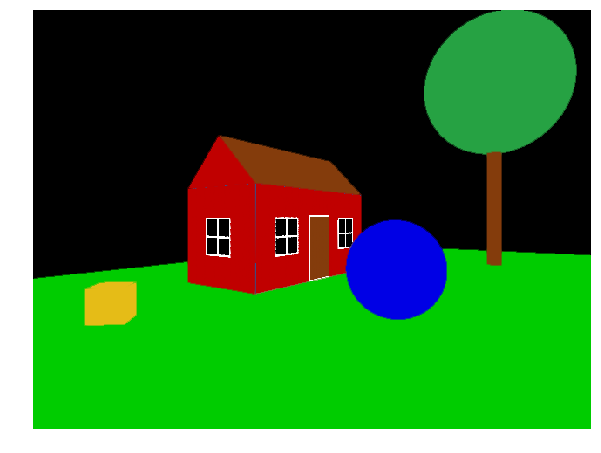

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(image2.data)
plt.axis('off')

Once we are happy with the result, we can save the images.

In [15]:
image.save("scene-1a.png")
image2.save("scene-1b.png")

Next we add a point light source to the scene and render again.

In [16]:
scene.addLight(PointLight(Vec3(6,-12,3)))

In [17]:
image3 = engine.render(scene)

# RENDER STATISTICS###############################
TIME FOR RENDERING: 159.49769568443298s
NUMBER OF PRIMARY RAYS: 307200
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 194780
RAYS/s: 3147.255500124403
##################################################


(-0.5, 639.5, 479.5, -0.5)

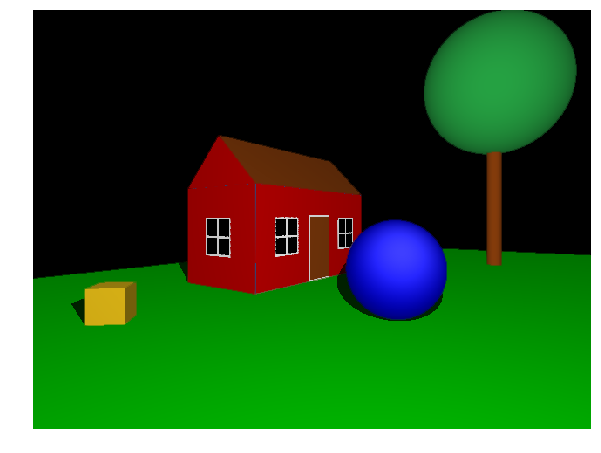

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(image3.data)
plt.axis('off')

In [19]:
image3.save("scene-1c.png")

## Depth of field
For demonstrating varying depth of field we create a scene with a large depth range.

In [20]:
scene2 = Scene()

In [21]:
scene2.addLight(AmbientLight(brightness=0.7))
scene2.addLight(PointLight(Vec3(-3,-15,10)))

As a floor we use a chessboard pattern.

In [22]:
x, y = np.meshgrid(range(8),range(8))
z = np.mod(x + y, 2)
z = np.kron(z,np.ones((128,128))) * 255
texture = np.stack([z, z, z], axis=2).astype(np.uint8)

In [23]:
scene2.add(PlanarTexture(Vec3(-10,-11,0),Vec3(20,0,0),Vec3(0,20,0),texture, white))
scene2.add(Sphere(Vec3(0.0,-9.5,1.), 1., ball))
scene2.add(Sphere(Vec3(5.0,-5.5,1.), 1., ball))
scene2.add(Sphere(Vec3(-5.0,-1.5,1.), 1., ball))
scene2.add(Sphere(Vec3(0.0,2.5,1.), 1., ball))
scene2.add(Sphere(Vec3(5.0,6.5,1.), 1., ball))

In [24]:
camera.setView(Vec3(0.1,-15.,5.), Vec3(0,0.,0.), Vec3(0.,0.,1.))
scene2.setCamera(camera)

In [25]:
image4 = engine.render(scene2)

# RENDER STATISTICS###############################
TIME FOR RENDERING: 74.77261447906494s
NUMBER OF PRIMARY RAYS: 307200
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 196883
RAYS/s: 6741.5457318418985
##################################################


Here is the RGB image.

(-0.5, 639.5, 479.5, -0.5)

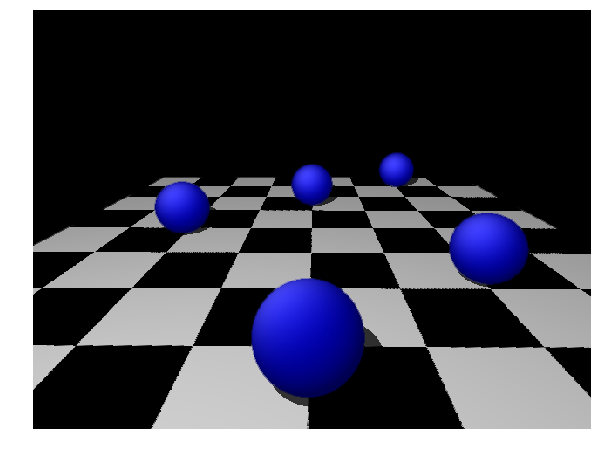

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(image4.data)
plt.axis('off')

This is the corresponding depth image.

(-0.5, 639.5, 479.5, -0.5)

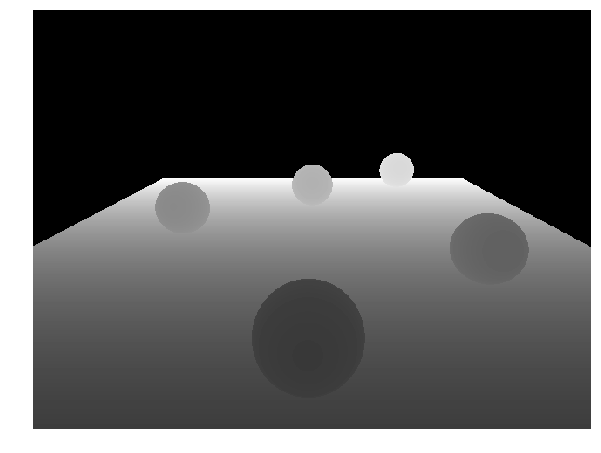

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(image4.depth,cmap='gray')
plt.axis('off')

For simulating varying depth of field and focusing the image at distance ${\bf focus}$ we use the following function.

In [28]:
def image_focusing(image, depth, focus):
    depth=np.clip(depth,1,20)
    stacked=np.zeros((image.shape[0],image.shape[1],3,20)).astype(np.uint8)
    for i in range(20):
        sigma=i/19*6
        rad = int(sigma*3)
        stacked[:,:,:,i] = cv2.GaussianBlur(image,(2*rad+1,2*rad+1),sigma,sigma)
    ind = (np.arange(256)/256*20).astype(np.uint8)
    blur_ind = ind[(np.clip(abs(depth-focus)*12.75, 0, 255)).astype(np.uint8)]
    blurred = np.zeros(image.shape).astype(np.uint8)
    for i in range(20):
        mask = (blur_ind == i).astype(np.uint8)
        blurred += cv2.bitwise_and(stacked[:,:,:,i], stacked[:,:,:,i], mask = mask)
    return blurred

This is the first image focused at foreground (6 m).

In [29]:
focused1 = image_focusing(image4.data,image4.depth,6)

(-0.5, 639.5, 479.5, -0.5)

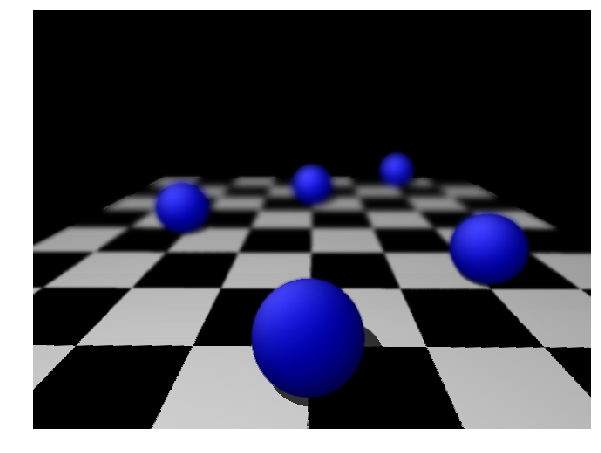

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(focused1)
plt.axis('off')

This is the second image focused at infinity (20 m)

In [31]:
focused2 = image_focusing(image4.data,image4.depth,20)

(-0.5, 639.5, 479.5, -0.5)

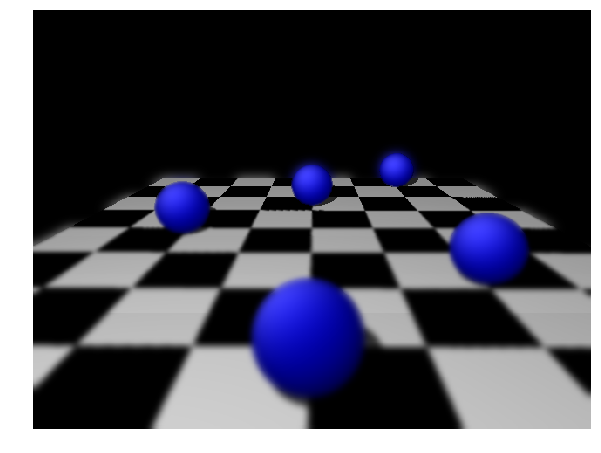

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(focused2)
plt.axis('off')

In [33]:
cv2.imwrite("focused1.png", cv2.cvtColor(focused1,cv2.COLOR_RGB2BGR))
cv2.imwrite("focused2.png", cv2.cvtColor(focused2,cv2.COLOR_RGB2BGR))

True

## Lens distortion
We change the lens to correspond to a wide field of view (120 degrees) and render a new image.

In [34]:
camera = PerspectiveCamera(width, height, 120)
camera.setView(Vec3(5,-10.,2.), Vec3(0,0.,0.), Vec3(0.,0.,1.))
scene2.setCamera(camera)

In [35]:
image5 = engine.render(scene2)

# RENDER STATISTICS###############################
TIME FOR RENDERING: 68.18515682220459s
NUMBER OF PRIMARY RAYS: 307200
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 158850
RAYS/s: 6835.0653092320845
##################################################


(-0.5, 639.5, 479.5, -0.5)

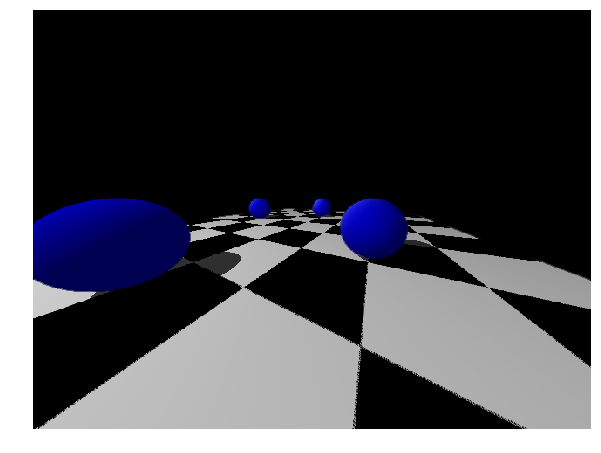

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(image5.data)
plt.axis('off')

Using this image we create another image with radial distortion.

In [37]:
img = image5.data

In [38]:
xi, yi = np.meshgrid(range(img.shape[1]),range(img.shape[0]))

In [39]:
xi = xi.astype(np.float32) - img.shape[1]/2
yi = yi.astype(np.float32) - img.shape[0]/2

In [40]:
ri2 = xi**2 + yi**2

In [41]:
k1 = 0.000005      #only one parameter

In [42]:
xd = xi * (1 + k1 * ri2)
yd = yi * (1 + k1 * ri2)

In [43]:
xd = xd/xd.max()*xi.max()
yd = yd/yd.max()*yi.max()

In [44]:
xd = xd + img.shape[1]/2
yd = yd + img.shape[0]/2

In [45]:
dist = cv2.remap(img, xd, yd, cv2.INTER_LINEAR)

Here are both images: undistorted and distorted.

(-0.5, 639.5, 479.5, -0.5)

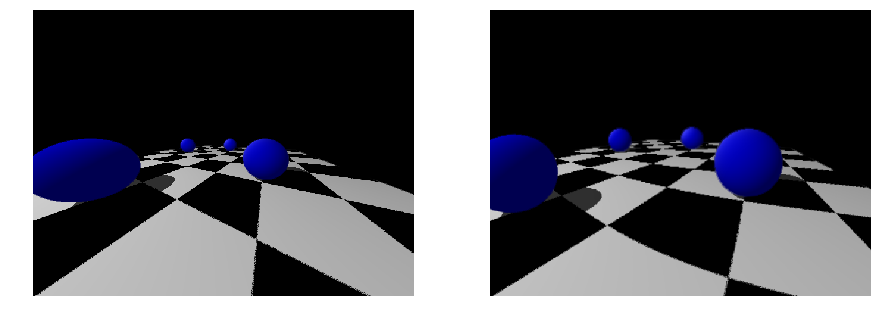

In [46]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.subplot(122)
plt.imshow(dist)
plt.axis('off')

In [47]:
cv2.imwrite("wide_angle.png", cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
cv2.imwrite("wide_angle_distorted.png", cv2.cvtColor(dist,cv2.COLOR_RGB2BGR))

True

## Vignetting
Next we simulate the effect of brightness falloff towards the image boundaries using the "cosine fourth" law.

In [48]:
img = cv2.imread("images/landscape.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [49]:
xi, yi = np.meshgrid(range(img.shape[1]),range(img.shape[0]))
xi = xi.astype(np.float32) - img.shape[1]/2
yi = yi.astype(np.float32) - img.shape[0]/2
di = np.sqrt(xi**2 + yi**2)

In [50]:
f = 500       #This is the focal length we assume

In [51]:
alpha = np.arctan2(di,f)

In [52]:
falloff = np.cos(alpha)**4
falloff = np.stack([falloff, falloff, falloff], axis=2)

In [53]:
vig = (img * falloff).astype(np.uint8)

(-0.5, 921.5, 517.5, -0.5)

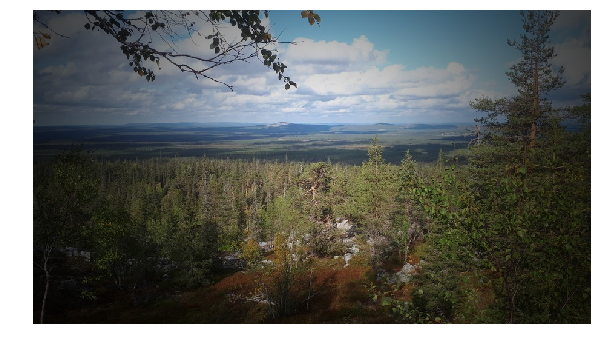

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(vig)
plt.axis('off')

In [55]:
cv2.imwrite("vignetting.png", cv2.cvtColor(vig,cv2.COLOR_RGB2BGR))

True

## Demosaicing
Here we simulate image acquisition with the Bayer color filter array (CFA) and conversion to an RGB image.

In [56]:
img = cv2.imread('images/fruits.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

This is the basic Bayer pattern.

In [57]:
bmask = np.zeros((2,2,3))
bmask[1,0,0] = 1
bmask[0,0,1] = 1
bmask[1,1,1] = 1
bmask[0,1,2] = 1

The CFA is created by repeating the pattern to cover all pixels of the image.

In [58]:
bpattern = np.kron(np.ones((int((img.shape[0]/2)), int(img.shape[1]/2), 1)), bmask).astype(np.uint8)

Here is a small part of the CFA.

(-0.5, 6.5, 6.5, -0.5)

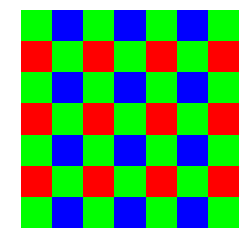

In [59]:
plt.imshow(bpattern[0:7,0:7]*255)
plt.axis('off')

Next we filter the image to simulate the output of the image sensor.

In [60]:
bayer = img * bpattern
bayer = np.sum(bayer, axis = 2)

Notice that the result has only one channel. Then, we use the color transformation from OpenCV to perform demosaicing (converting the filtered image to an RGB image with three channels).

In [61]:
debayer = cv2.cvtColor(bayer.astype(np.uint8),cv2.COLOR_BAYER_GR2RGB)

(-0.5, 511.5, 479.5, -0.5)

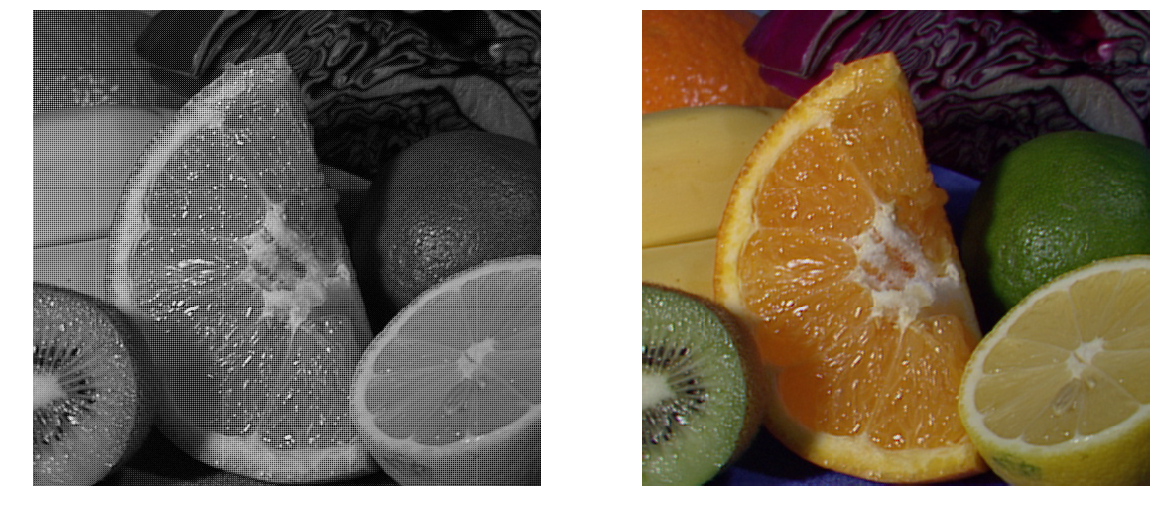

In [62]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(bayer,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(debayer)
plt.axis('off')

In [63]:
cv2.imwrite("bayer.png", bayer)
cv2.imwrite("debayer.png", cv2.cvtColor(debayer,cv2.COLOR_RGB2BGR))

True

## Gamma correction
There is nonlinear relationship between the real intensity and the brightness what we perceive.

In [64]:
brightness, _ = np.meshgrid(np.linspace(0,1,512),range(0,100))

In [65]:
intensity = brightness**2.22

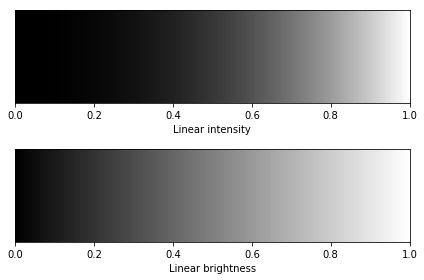

In [66]:
plt.subplot(211)
plt.imshow(intensity,cmap='gray',extent=[0,1,0,1], aspect='auto')
plt.yticks([])
plt.xlabel('Linear intensity')
plt.tight_layout()
plt.subplot(212)
plt.imshow(brightness,cmap='gray',extent=[0,1,0,1], aspect='auto')
plt.yticks([])
plt.xlabel('Linear brightness')
plt.tight_layout()
plt.savefig('linscale.png')

That is why the images need to be gamma pre-corrected in the camera to make them better suited for the human eye. The next example shows how the image looks like without gamma pre-correction.

In [67]:
before_gamma = (((img/255.0)**2.22)*255.0).astype(np.uint8)

(-0.5, 511.5, 479.5, -0.5)

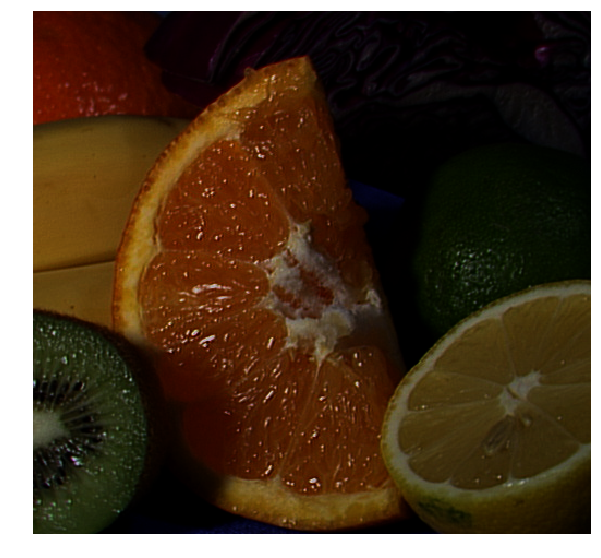

In [68]:
plt.figure(figsize=(10,10))
plt.imshow(before_gamma)
plt.axis('off')

In [69]:
cv2.imwrite("before_gamma.png", cv2.cvtColor(before_gamma, cv2.COLOR_RGB2BGR))

True

## Image noise
Here we generate two images with realistic shot noise. The first image represents low illumination conditions or short exposure time. In the second image the exposure (= amount of light per unit area) is 10 times higher.

In [70]:
scale = 1.0
image1 = np.zeros((256,256,3), dtype=np.uint8)
for i in range(256):
    image1[:,i,:] = np.clip(np.random.poisson(i*scale,(256,3))/scale, 0, 255).astype(np.uint8)

In [71]:
scale = 10.0
image2 = np.zeros((256,256,3), dtype=np.uint8)
for i in range(256):
    image2[:,i,:] = np.clip(np.random.poisson(i*scale,(256,3))/scale, 0, 255).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

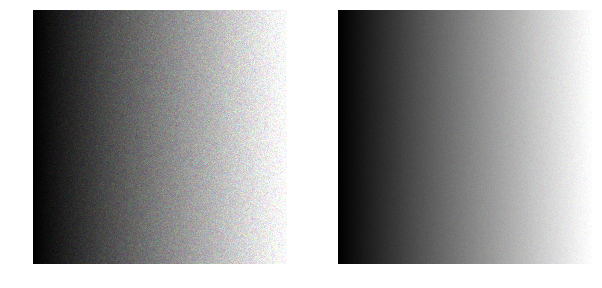

In [72]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(image1)
plt.axis('off')
plt.subplot(122)
plt.imshow(image2)
plt.axis('off')

## White balance
Here we distort the color balance of an image by multiplying the R channel with 0.7 and the B channel with 1.5.

In [73]:
wb = img.copy()
wb[:,:,0] = np.clip(wb[:,:,0]*0.7, 0, 255).astype(np.uint8)
wb[:,:,2] = np.clip(wb[:,:,2]*1.5, 0, 255).astype(np.uint8)

(-0.5, 511.5, 479.5, -0.5)

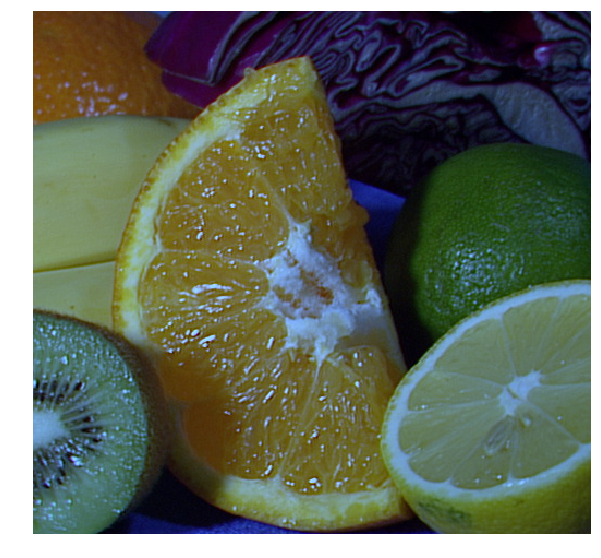

In [74]:
plt.figure(figsize=(10,10))
plt.imshow(wb)
plt.axis('off')

In [75]:
cv2.imwrite("incorrect_white_balance.png", cv2.cvtColor(wb, cv2.COLOR_RGB2BGR))

True